Quantized Transfer Learning for Tree Canopy Assessment
========================================================


In [ ]:
# Imports
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time
plt.ion()


   pip install numpy
   pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html


In [ ]:
!yes y | pip uninstall torch torchvision
!yes y | pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

Found existing installation: torch 1.9.0+cu102
Uninstalling torch-1.9.0+cu102:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/lib/python3.7/dist-packages/caffe2/*
    /usr/local/lib/python3.7/dist-packages/torch-1.9.0+cu102.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torch/*
Proceed (y/n)? y
  Successfully uninstalled torch-1.9.0+cu102
Found existing installation: torchvision 0.10.0+cu102
Uninstalling torchvision-0.10.0+cu102:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/torchvision-0.10.0+cu102.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libcudart.459720b2.so.10.2
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libjpeg.ceea7512.so.62
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libnvjpeg.a6b52b54.so.10
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libpng16.7f72a3c5.so.16
    /usr/local/lib/python3.7/dist-packages/torchvision.

In [ ]:
import requests
import os
import zipfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torchvision import transforms, datasets

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = 'data/hymenoptera_data'
data_dir = '/content/drive/MyDrive/treecanopy'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': 1428, 'val': 358}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Visualize a few images


Let's visualize a few training images so as to understand the data
augmentations.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


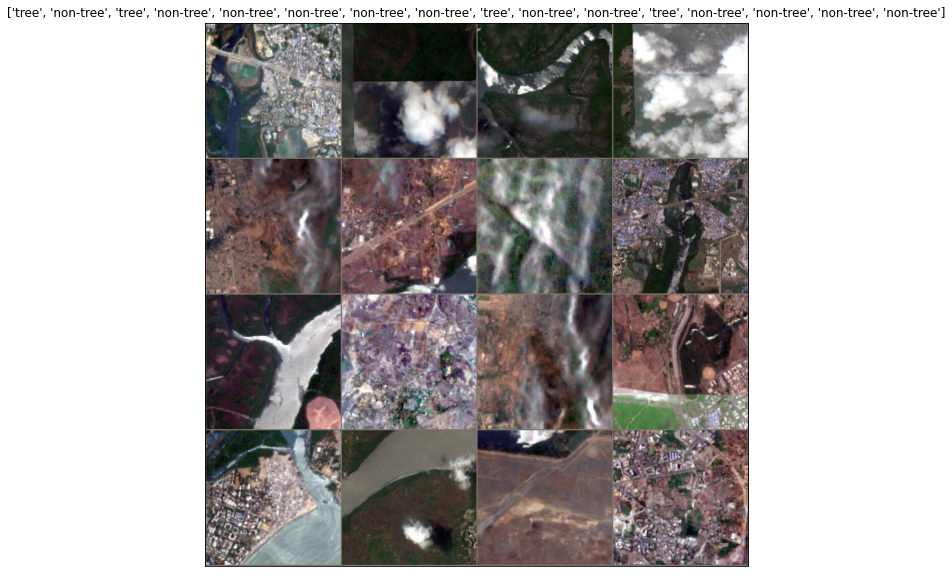

In [ ]:
import torchvision

def imshow(inp, title=None, ax=None, figsize=(4, 4)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, title=[class_names[x] for x in classes], ax=ax)

### Support Function for Model Training

Below is a generic function for model training.
This function also

- Schedules the learning rate
- Saves the best model



In [ ]:
val_losses = []
train_losses = []
val_accuracy = []
train_accuracy = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cpu'):
      """
      Support function for model training.
      Args:
        model: Model to be trained
        criterion: Optimization criterion (loss)
        optimizer: Optimizer to use for training
        scheduler: Instance of ``torch.optim.lr_scheduler``
        num_epochs: Number of epochs
        device: Device to run the training on. Must be 'cpu' or 'cuda'
      """
      since = time.time()

      best_model_wts = copy.deepcopy(model.state_dict())
      best_acc = 0.0

      for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
          if phase == 'train':
            model.train()  # Set model to training mode
          else:
            model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              if phase == 'train':
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
          if phase == 'train':
            scheduler.step()

          epoch_loss = running_loss / dataset_sizes[phase]
          epoch_acc = running_corrects.double() / dataset_sizes[phase]
          
          print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
          
          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        print()
      time_elapsed = time.time() - since
      print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
      print('Best val Acc: {:4f}'.format(best_acc))
      # load best model weights
      model.load_state_dict(best_model_wts)

      return model      

### Support Function for Visualizing the Model Predictions

Generic function to display predictions for a few images




In [ ]:
 def visualize_model(model, rows=3, cols=3):
      was_training = model.training
      model.eval()
      current_row = current_col = 0
      fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

      with torch.no_grad():
        for idx, (imgs, lbls) in enumerate(dataloaders['val']):
          imgs = imgs.cpu()
          lbls = lbls.cpu()

          outputs = model(imgs)
          _, preds = torch.max(outputs, 1)

          for jdx in range(imgs.size()[0]):
            imshow(imgs.data[jdx], ax=ax[current_row, current_col])
            ax[current_row, current_col].axis('off')
            ax[current_row, current_col].set_title('predicted: {}'.format(class_names[preds[jdx]]))

            current_col += 1
            if current_col >= cols:
              current_row += 1
              current_col = 0
            if current_row >= rows:
              model.train(mode=was_training)
              return
        model.train(mode=was_training)


## Part 1. Training a Custom Classifier based on a Quantized Feature Extractor 



Load a pretrained model: for this exercise you will be using [ResNet-18](https://pytorch.org/hub/pytorch_vision_resnet/).



In [ ]:
import torchvision.models.quantization as models
# We will need the number of filters in the `fc` for future use.
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_fe = models.resnet18(pretrained=True, progress=True, quantize=True)
num_ftrs = model_fe.fc.in_features

/usr/local/lib/python3.7/dist-packages/torch/quantization/observer.py:124: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Downloading: "https://download.pytorch.org/models/quantized/resnet18_fbgemm_16fa66dd.pth" to /root/.cache/torch/hub/checkpoints/resnet18_fbgemm_16fa66dd.pth


  0%|          | 0.00/11.2M [00:00<?, ?B/s]

At this point you need to modify the pretrained model. The model
has the quantize/dequantize blocks in the beginning and the end. However,
because you will only use the feature extractor, the dequantizatioin layer has
to move right before the linear layer (the head). The easiest way to do that
is to wrap the model in the ``nn.Sequential`` module.

The first step is to isolate the feature extractor in the ResNet
model. Although in this example you are tasked to use all layers except
``fc`` as the feature extractor, in reality, you can take as many parts
as you need. This would be useful in case you would like to replace some
of the convolutional layers as well.

The function -- creates a model with a custom head.

In [ ]:

from torch import nn

def create_combined_model(model_fe):
  # Step 1. Isolate the feature extractor.
  model_fe_features = nn.Sequential(
    model_fe.quant,  # Quantize the input
    model_fe.conv1,
    model_fe.bn1,
    model_fe.relu,
    model_fe.maxpool,
    model_fe.layer1,
    model_fe.layer2,
    model_fe.layer3,
    model_fe.layer4,
    model_fe.avgpool,
    model_fe.dequant,  # Dequantize the output
  )

  # Step 2. Create a new "head"
  new_head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, len(class_names)),
 #   nn.Linear(num_ftrs, 7),
  )

  # Step 3. Combine, and don't forget the quant stubs.
  new_model = nn.Sequential(
    model_fe_features,
    nn.Flatten(1),
    new_head,
  )
  return new_model


**Warning:** Currently the quantized models can only be run on CPU.
  However, it is possible to send the non-quantized parts of the model to a GPU.

In [ ]:
import torch.optim as optim
new_model = create_combined_model(model_fe)
new_model = new_model.to('cpu')
criterion = nn.CrossEntropyLoss()

# Note that we are only training the head.
optimizer_ft = optim.SGD(new_model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate



In [ ]:
new_model = train_model(new_model, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=25, device='cpu')

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8464 Acc: 0.7038
val Loss: 0.2825 Acc: 0.9022

Epoch 1/24
----------
train Loss: 0.8975 Acc: 0.7661
val Loss: 0.3323 Acc: 0.8855

Epoch 2/24
----------
train Loss: 0.9048 Acc: 0.7724
val Loss: 0.2556 Acc: 0.9106

Epoch 3/24
----------
train Loss: 1.2198 Acc: 0.7220
val Loss: 0.3509 Acc: 0.8799

Epoch 4/24
----------
train Loss: 1.1476 Acc: 0.7633
val Loss: 0.3350 Acc: 0.9022

Epoch 5/24
----------
train Loss: 1.0699 Acc: 0.7808
val Loss: 0.4086 Acc: 0.8799

Epoch 6/24
----------
train Loss: 1.1676 Acc: 0.7703
val Loss: 0.3669 Acc: 0.8855

Epoch 7/24
----------
train Loss: 0.9090 Acc: 0.7983
val Loss: 0.3008 Acc: 0.8939

Epoch 8/24
----------
train Loss: 0.8798 Acc: 0.7899
val Loss: 0.2699 Acc: 0.8966

Epoch 9/24
----------
train Loss: 0.8394 Acc: 0.8032
val Loss: 0.2549 Acc: 0.9050

Epoch 10/24
----------
train Loss: 0.7277 Acc: 0.7990
val Loss: 0.2576 Acc: 0.8966

Epoch 11/24
----------
train Loss: 0.7351 Acc: 0.8046
val Loss: 0.2406 Acc: 0.9078

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


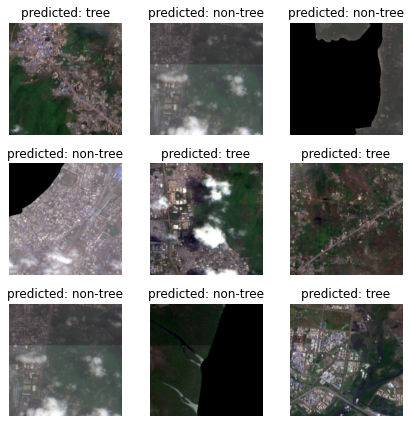

In [ ]:
visualize_model(new_model)

plt.tight_layout()

In [ ]:
print(new_model)

Sequential(
  (0): Sequential(
    (0): Quantize(scale=tensor([0.0374]), zero_point=tensor([57]), dtype=torch.quint8)
    (1): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.028605546802282333, zero_point=0, padding=(3, 3))
    (2): Identity()
    (3): Identity()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): Sequential(
      (0): QuantizableBasicBlock(
        (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.016524722799658775, zero_point=0, padding=(1, 1))
        (bn1): Identity()
        (relu): Identity()
        (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.04645531252026558, zero_point=75, padding=(1, 1))
        (bn2): Identity()
        (add_relu): QFunctional(
          scale=0.03447607904672623, zero_point=0
          (activation_post_process): Identity()
        )
      )
      (1): QuantizableBasicBlock(
        (conv1): QuantizedConvReLU2d(64,

## Part 2. Finetuning the Quantizable Model


In this part, we fine tune the feature extractor used for transfer
learning, and quantize the feature extractor. Note that in both part 1
and 2, the feature extractor is quantized. The difference is that in
part 1, we use a pretrained quantized model. In this part, we create a
quantized feature extractor after fine tuning on the data-set of
interest, so this is a way to get better accuracy with transfer learning
while having the benefits of quantization. Note that in our specific
example, the training set is really small (120 images) so the benefits
of fine tuning the entire model is not apparent. However, the procedure
shown here will improve accuracy for transfer learning with larger
datasets.

The pretrained feature extractor must be quantizable.
To make sure it is quantizable, perform the following steps:

 1. Fuse ``(Conv, BN, ReLU)``, ``(Conv, BN)``, and ``(Conv, ReLU)`` using
    ``torch.quantization.fuse_modules``.
 2. Connect the feature extractor with a custom head.
    This requires dequantizing the output of the feature extractor.
 3. Insert fake-quantization modules at appropriate locations
    in the feature extractor to mimic quantization during training.

For step (1), we use models from ``torchvision/models/quantization``, which
have a member method ``fuse_model``. This function fuses all the ``conv``,
``bn``, and ``relu`` modules. For custom models, this would require calling
the ``torch.quantization.fuse_modules`` API with the list of modules to fuse
manually.

Step (2) is performed by the ``create_combined_model`` function
used in the previous section.

Step (3) is achieved by using ``torch.quantization.prepare_qat``, which
inserts fake-quantization modules.


As step (4), you can start "finetuning" the model, and after that convert
it to a fully quantized version (Step 5).

To convert the fine tuned model into a quantized model you can call the
``torch.quantization.convert`` function (in our case only
the feature extractor is quantized).

**Note:** Because of the random initialization your results might differ from
   the results shown in this tutorial.

In [ ]:
# notice `quantize=False`
model = models.resnet18(pretrained=True, progress=True, quantize=False)
num_ftrs = model.fc.in_features

# Step 1
model.train()
model.fuse_model()
# Step 2
model_ft = create_combined_model(model)
model_ft[0].qconfig = torch.quantization.default_qat_qconfig  # Use default QAT configuration
# Step 3
model_ft = torch.quantization.prepare_qat(model_ft, inplace=True)



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/quantization/observer.py:124: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."


### Finetuning the model

In the current tutorial the whole model is fine tuned. In
general, this will lead to higher accuracy. However, due to the small
training set used here, we end up overfitting to the training set.


Step 4. Fine tune the model


In [ ]:
for param in model_ft.parameters():
  param.requires_grad = True

model_ft.to(device)  # We can fine-tune on GPU if available

criterion = nn.CrossEntropyLoss()

# Note that we are training everything, so the learning rate is lower
# Notice the smaller learning rate
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

# Decay LR by a factor of 0.3 every several epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.3)

model_ft_tuned = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                              num_epochs=25, device=device)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4884 Acc: 0.7703
val Loss: 0.1726 Acc: 0.9274

Epoch 1/24
----------
train Loss: 0.3260 Acc: 0.8648
val Loss: 0.1403 Acc: 0.9497

Epoch 2/24
----------
train Loss: 0.2316 Acc: 0.9020
val Loss: 0.1249 Acc: 0.9609

Epoch 3/24
----------
train Loss: 0.2355 Acc: 0.9076
val Loss: 0.1054 Acc: 0.9609

Epoch 4/24
----------
train Loss: 0.1848 Acc: 0.9279
val Loss: 0.0916 Acc: 0.9693

Epoch 5/24
----------
train Loss: 0.1188 Acc: 0.9573
val Loss: 0.0574 Acc: 0.9832

Epoch 6/24
----------
train Loss: 0.1171 Acc: 0.9636
val Loss: 0.0534 Acc: 0.9860

Epoch 7/24
----------
train Loss: 0.1126 Acc: 0.9622
val Loss: 0.0476 Acc: 0.9888

Epoch 8/24
----------
train Loss: 0.0983 Acc: 0.9706
val Loss: 0.0415 Acc: 0.9888

Epoch 9/24
----------
train Loss: 0.0975 Acc: 0.9671
val Loss: 0.0360 Acc: 0.9860

Epoch 10/24
----------
train Loss: 0.0776 Acc: 0.9839
val Loss: 0.0396 Acc: 0.9832

Epoch 11/24
----------
train Loss: 0.0786 Acc: 0.9769
val Loss: 0.0403 Acc: 0.9916

Epoch 12/24
----------
t

Step 5. Convert to quantized model


In [ ]:
from torch.quantization import convert
model_ft_tuned.cpu()

model_quantized_and_trained = convert(model_ft_tuned, inplace=False)


Lets see how the quantized model performs on a few images


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


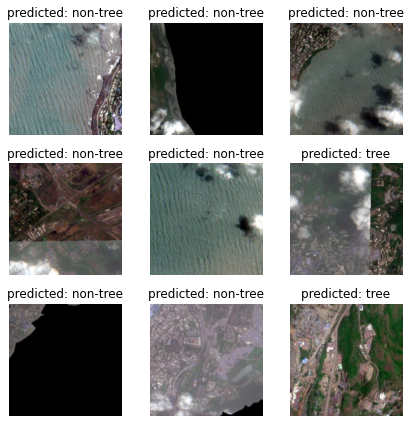

In [ ]:
visualize_model(model_quantized_and_trained)

plt.ioff()
plt.tight_layout()
plt.show()

In [ ]:
 print("Quantized and Trained Model")
 print(model_quantized_and_trained)

Quantized and Trained Model
Sequential(
  (0): Sequential(
    (0): Quantize(scale=tensor([0.0375]), zero_point=tensor([57]), dtype=torch.quint8)
    (1): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.017025675624608994, zero_point=0, padding=(3, 3))
    (2): Identity()
    (3): Identity()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): Sequential(
      (0): QuantizableBasicBlock(
        (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.01099139079451561, zero_point=0, padding=(1, 1))
        (bn1): Identity()
        (relu): Identity()
        (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.033163126558065414, zero_point=72, padding=(1, 1))
        (bn2): Identity()
        (add_relu): QFunctional(
          scale=0.019536932930350304, zero_point=0
          (activation_post_process): Identity()
        )
      )
      (1): QuantizableBasicBlock(
        (co